## Astronomy 406 "Computational Astrophysics" (Fall 2024)

## Project 5: Advanced Regression

### Michael Struk



### Background

In this project we will continue our investigation of fitting model to data. We will use a new dataset __mgc_mh.dat__ which contains a current version of the relation between the mass of a globular cluster system and its host galaxy. Instead of the host luminosity, it uses the full dynamical mass of the host galaxy $M_h$, including its dark matter halo. The columns are: galaxy mass $\log_{10}{M_h}$, its error estimate $d\log_{10}{M_h}$, combined mass of all globular clusters in each galaxy $\log_{10}{M}_{GC}\;$, and its error estimate $d\log_{10}{M}_{GC}\;$. All four variables are logarithmic and in units of solar mass.

The resulting relation is very close to linear betwen the actual values of $M_{GC}\,$ and $M_h$, not just their logarithms. In other words, the globular cluster system mass is simply proportional to the total galaxy mass. Such a linear relation was unexpected when it was [first discovered](https://ui.adsabs.harvard.edu/abs/2013ApJ...772...82H/abstract) because the spatial scales of star clusters and dark matter halos are vastly different (by a factor $\sim 10,000$), but now it became an important test for [models of globular cluster formation](https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.5409C/abstract). It is important to determine, beyond observational measurement errors, whether the slope of the relation $M_{GC}\, \propto {M_h}^b$ is exactly $b=1$ or not.

We will express the relation again as

$$ y = f(x | a,b,\sigma) = a + b x + \epsilon $$

and maximize the log-likelihood as a function of three parameters:

$$ 2\ln{\cal L}(a,b,\sigma) = -\sum_i \ln{\sigma_i^2} - \sum_i {(y_i - a - b x_i)^2 \over \sigma_i^2} $$

with $\sigma_i^2 \equiv \sigma_{y,i}^2 + b^2 \sigma_{x,i}^2 + \sigma^2$.


### Learning goals

* Practice determining the best-fit values, error distribution, and correlations between parameters of a linear regression fit.



* Investigate different formulations of linear fit: forward, reverse, and orthogonal, and evaluate the true uncertainty in the fit slope.



* Minimize correlations between model parameters by using a pivot point for the observed data sample. 

### Task

__Required part:__

__Continue your investigation:__

Explore the effect of adding a pivot point to the dataset. Repeat the original, reverse, and orthogonal fits with the appropriate offset in $x$ or $y$. Investigate how the correlation between parameters $a$ and $b$ varies depending on the chosen offset.

Continue this investigation as far as you like. I hope you can take it further than I did!

In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import warnings # For latex plotting warnings
warnings.filterwarnings("ignore")

# Reading in the data
Mh, dMh, MGC, dMGC = np.loadtxt('Data/mgc_mh.dat', unpack=True)

## Task 1

1. Write a routine for log-likelihood of the data points and maximize it __for the new dataset__. Plot the data and best-fit line with errors, on the same plot.<br>
    

Forward fit: a = 5.6330 +- 0.0007  b = 0.8628 +- 0.0088  sig = -0.2061 +- 0.0088


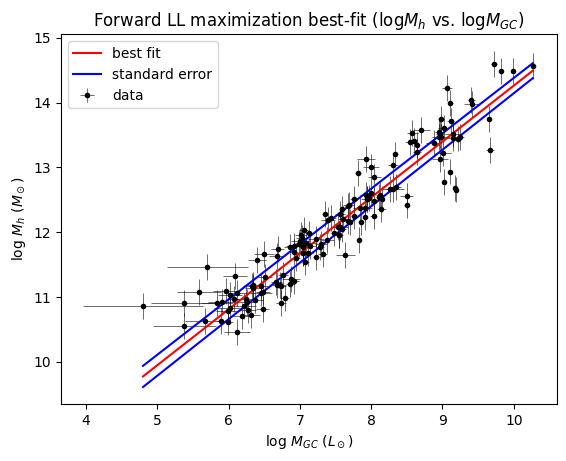

In [112]:
def logLikelihood(params, xb, yb, dxb, dyb):
    '''
    Computes the log-likelihood for a linear model with uncertainties.

    Args:
        params (list): Model parameters [a, b, sig], where:
            a (float): Intercept of the linear model.
            b (float): Slope of the linear model.
            sig (float): Intrinsic scatter term.
        xb (array-like): Independent variable data.
        yb (array-like): Dependent variable data.
        dxb (array-like): Uncertainty in xb.
        dyb (array-like): Uncertainty in yb.

    Returns:
        float: Log-likelihood value.
    '''
    a = params[0]
    b = params[1]
    sig = params[2]
    sigi2 = dyb**2 + (b**2)*dxb**2 +sig**2
    return -(-np.sum(np.log((sigi2)))-np.sum(((yb - a - b*xb)**2) / (sigi2)))

# Maximizing the loglikelihood for linear fitting of Mh vs. MGC
o = optimize.minimize(logLikelihood, [1.,1.,1.], args=(MGC, Mh, dMGC, dMh)) # MGC=x, Mh=y
a = o.x[0]
b = o.x[1]
sig = o.x[2]
da = np.sqrt(o.hess_inv[0,0])
db = np.sqrt(o.hess_inv[1,1])
dsig = np.sqrt(o.hess_inv[2,2])
print('Forward fit: a = %.4f +- %.4f  b = %.4f +- %.4f  sig = %.4f +- %.4f'%(a, da, b, db, sig, dsig))

# x-values to plot best fit over
xa = np.linspace(np.min(MGC), np.max(MGC))

# Plotting
plt.errorbar(MGC, Mh, xerr=dMGC, yerr=dMh, fmt='.k', elinewidth=0.4, capsize=0, label='data')
plt.plot(xa, a + b*xa, 'r-', label='best fit')
plt.plot(xa, a+da+sig + (b+db)*xa, 'b-', label='standard error')
plt.plot(xa, a-da-sig + (b-db)*xa, 'b-')

plt.legend()
plt.title('Forward LL maximization best-fit (log$M_h$ vs. log$M_{GC}$)')
plt.xlabel(r'log $M_{GC} \ (L_\odot)$');
plt.ylabel(r'log $M_h \ (M_\odot)$');

## Task 2

2. Calculate bootstrap samples of the fit parameters until convergence, as in Project 4.<br>

In [66]:
# Function for calculating the fit parameters' numerical convergence within bootstrapping realizations

def convergence_criterion(param_std, param_std_last, epserr):
    """
    Check if the standard deviation of bootstrap parameters has converged within a given tolerance.

    Parameters:
    param_std : list of float
        A list containing the current standard deviations of the parameters from the latest bootstrap iteration.
    param_std_last : list of float
        A list containing the standard deviations of the parameters from the previous bootstrap iteration.
    epserr : float
        The convergence tolerance. If the difference between the standard deviations of consecutive 
        iterations is less than `eps`, the corresponding parameter is considered to have converged.

    Returns:
    results : list of bool
        A list where each element indicates whether the corresponding parameter's standard deviation 
        has converged (True if the difference is less than `eps`, False otherwise).
    ds : list of float
        A list of the absolute differences between the current and previous standard deviations for each parameter.
    """
    ds = []
    results = []
    for i in range(len(param_std)):  # Iterate over each parameter (for a, b, sig)
        d = abs(param_std[i] - param_std_last[i])
        #print(d)
        if d < epserr:
            results.append(True)
            ds.append(d)
        else:
            results.append(False)
            ds.append(d)
    return results, ds

#### Bootstrapping

In [34]:
######## Setting up bootstrapping ########

np.random.seed(0) # Orderly production of random resamples

pboot = [[], [], []]    # empty 2D array that will hold all bootstrap parameters
pmeans = []       # empty list to collect the means after each batch
pstds = []        # empty list to collect the stds after each batch
eps = 0.001       # convergence criterion

In [102]:
######## Bootstrap intercept (parameter a) ########

iboot = 0         # counter of bootstrap realizations
prev_pstd = None # initialize the std of the previous loop

while True:
    for j in range(50): # run bootstraps in batches of 50
        
        iboot += 1
        
        ir = np.random.randint(low=0, high=len(MGC), size=len(MGC))  # random numbers from 0 to N-1
        
        xb = MGC[ir]; yb = Mh[ir]; dxb = dMGC[ir]; dyb = dMh[ir]       # bootstrap sample
        
        ob = optimize.minimize(logLikelihood, [1.,1.,1.], args=(xb, yb, dxb, dyb)) # maximize log likelihood
        
        [ pboot[i].append(ob.x[i]) for i in [0,1,2] ] # append results
        [ pmeans.append(np.mean(pboot[i])) for i in [0,1,2]]
        [ pstds.append(np.std(pboot[i])) for i in [0,1,2]]
    
    pmean = np.mean(pboot, axis=1) # means of the bootstrap parameter realizations
    pstd = np.std(pboot, axis=1) # standard deviations of the bootstrap parameter realizations
    
    if prev_pstd is not None:  # Only run if we have previous batch data for convergence comparison
        
        cond_a = convergence_criterion(pstd, prev_pstd, eps)[0][0] # Calculate whether or not they converged

        # Check the parameter's convergence
        if cond_a:
            print(f"parameter a converged after {iboot} bootstrap realizations") # Note the counts when the condition is satisfied
            a_boot, da_boot = pmean[0], pstd[0] # Store the values of the converged parameter mean and std
            print(f'a: {pmean[0]} +/- {pstd[0]}')
            break
                
    prev_pstd = pstd # The current set becomes the previous set for the next loop's comparison
    


parameter a converged after 100 bootstrap realizations
a: 5.613919939744897 +/- 0.2051529493049725


In [103]:
######## Bootstrap slope (parameter b) ########

np.random.seed(0) # Orderly production of random resamples

iboot = 0         # counter of bootstrap realizations

prev_pstd = None # initialize the std of the previous loop

while True:
    for j in range(50): # run bootstraps in batches of 50
        
        iboot += 1
        
        ir = np.random.randint(low=0, high=len(MGC), size=len(MGC))  # random numbers from 0 to N-1
        
        xb = MGC[ir]; yb = Mh[ir]; dxb = dMGC[ir]; dyb = dMh[ir]       # bootstrap sample
        
        ob = optimize.minimize(logLikelihood, [1.,1.,1.], args=(xb, yb, dxb, dyb)) # maximize log likelihood
        
        [ pboot[i].append(ob.x[i]) for i in [0,1,2] ] # append results
        [ pmeans.append(np.mean(pboot[i])) for i in [0,1,2]]
        [ pstds.append(np.std(pboot[i])) for i in [0,1,2]]
    
    pmean = np.mean(pboot, axis=1) # means of the bootstrap parameter realizations  
    pstd = np.std(pboot, axis=1) # standard deviations of the bootstrap parameter realizations
    
    if prev_pstd is not None:  # Only run if we have previous batch data for convergence comparison
        
        cond_b = convergence_criterion(pstd, prev_pstd, eps)[0][1] # Calculate whether or not they converged

        # Check the parameter's convergence
        if cond_b:
            print(f"parameter b converged after {iboot} bootstrap realizations")
            b_boot, db_boot = pmean[1], pstd[1]
            print(f'b: {pmean[1]} +/- {pstd[1]}')
            break
                
    prev_pstd = pstd # The current set becomes the previous set for the next loop's comparison

parameter b converged after 100 bootstrap realizations
b: 0.8656196647458544 +/- 0.027881723568350673


In [104]:
######## Bootstrap intrinsic scatter (parameter sig) ########

np.random.seed(0) # Orderly production of random resamples

iboot = 0         # counter of bootstrap realizations

prev_pstd = None # initialize the std of the previous loop

while True:
    for j in range(50): # run bootstraps in batches of 50
        
        iboot += 1
        
        ir = np.random.randint(low=0, high=len(MGC), size=len(MGC))  # random numbers from 0 to N-1
        
        xb = MGC[ir]; yb = Mh[ir]; dxb = dMGC[ir]; dyb = dMh[ir]       # bootstrap sample
        
        ob = optimize.minimize(logLikelihood, [1.,1.,1.], args=(xb, yb, dxb, dyb)) # maximize log likelihood
        
        [ pboot[i].append(ob.x[i]) for i in [0,1,2] ] # append results
        [ pmeans.append(np.mean(pboot[i])) for i in [0,1,2]]
        [ pstds.append(np.std(pboot[i])) for i in [0,1,2]]
    
    pmean = np.mean(pboot, axis=1) # means of the bootstrap parameter realizations
    pstd = np.std(pboot, axis=1) # standard deviations of the bootstrap parameter realizations
    
    if prev_pstd is not None:  # Only run if we have previous batch data for convergence comparison
        
        cond_sig = convergence_criterion(pstd, prev_pstd, eps)[0][2] # Calculate whether or not they converged

        # Check the parameter's convergence
        if cond_sig:
            print(f"parameter sig converged after {iboot} bootstrap realizations")
            sig_boot, dsig_boot = pmean[2], pstd[2]
            print(f'sig: {pmean[2]} +/- {pstd[2]}')
            break
                
    prev_pstd = pstd # The current set becomes the previous set for the next loop's comparison

parameter sig converged after 100 bootstrap realizations
sig: -0.176624560805185 +/- 0.09800877897541829


In [94]:
# Display results
print('bootstrapped forward fit parameters: a = %.4f +/- %.4f, b = %.4f +/- %.4f, sig = %.4f +/- %.4f'\
    %(a_boot, da_boot, b_boot, db_boot, sig_boot, dsig_boot))

bootstrapped forward fit parameters: a = 5.6194 +/- 0.2082, b = 0.8650 +/- 0.0283, sig = -0.1780 +/- 0.0958


### Task 3

3. Make a scatter plot of bootstrap values of $a$ and $b$, and overplot on the same figure the contours of $2\ln{\cal L}_{\rm max\;}-2\ln{\cal L}(a,b) = 1$ and 2.71, on a finely-spaced grid of $a$ and $b$. Keep the value of the intrinsic scatter fixed at the best value determined above. Here ${\cal L}_{\rm max}\,$ is the maximum (best-fit) value of the likelihood. Refer to `week6_advanced_fitting` notebook for an example. Experiment with the number of grid points that produce smooth contours. Do these contours align with the bootstrap distribution of $a$ and $b$?<br>

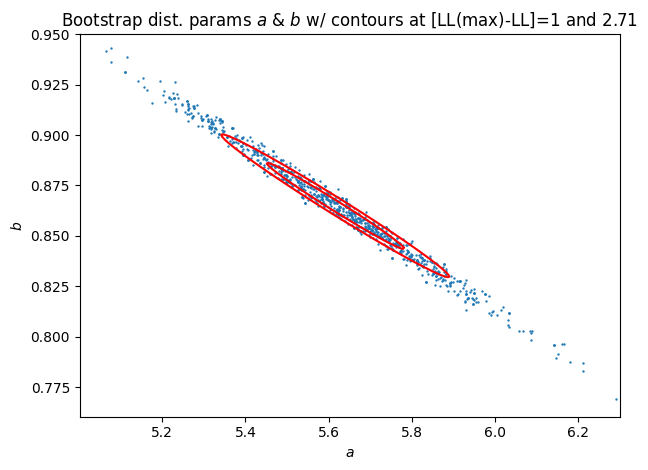

In [98]:
## Separate log-likelihood function for ease of calculation
def logLikelihood2( a, b, sig=sig_boot, x=MGC, y=Mh, dx=dMGC, dy=dMh ):
    w = 1./(sig**2 + dy**2 + (b*dx)**2)
    return np.sum(np.log(w) - w*(y-a-b*x)**2)

plt.scatter(pboot[0], pboot[1], s=0.5)
plt.xlabel('$a$')
plt.ylabel('$b$')

# number of points in a rectangular grid
na = 300
nb = 200
# rectangular grid with equal spacing
aaa = np.linspace(5.1, 6.3, num=na)
bbb = np.linspace(0.77, 0.95, num=nb)

# evaluate the likelihood on the grid
LL = np.ndarray((nb,na)) # grid to assign LL values to
for i in range(nb):
    for j in range(na):
        LL[i,j] = logLikelihood2(aaa[j], bbb[i])
LLdiff = np.amax(LL)-LL
        
# plot contours of the differential likelihood relative to its maximum value (LLdiff)
plt.contour(aaa, bbb, LLdiff, levels=[1, 2.71], colors='r', linesize=0.1)

plt.title('Bootstrap dist. params $a$ & $b$ w/ contours at [LL(max)-LL]=1 and 2.71')
plt.tight_layout()
plt.show()

* Using a grid of (300 x 200), the contours do smoothly align with the bootstrap distribution of $a$ and $b$.

## Task 4

4. Perform the reverse fit, that is, fit the model $x = c + d * y$, including intrinsic scatter. Add the best-fitting line to the first plot with the data and the forward fit.<br>

reverse fit: c = -5.1947 +- 0.2251  d = 1.0500 +- 0.0184  sig = 0.2377 +- 0.0173


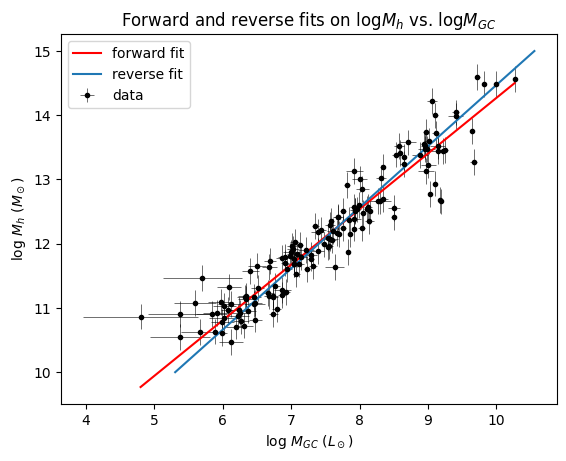

In [110]:
ya = np.linspace(10, 15)

def logLikelihood_rev(params, x, y, dx, dy):
    '''
    Computes the reverse log likelihood for given set of parameters and data.

    Similar to the loglikelihood function above, but is used to fit the function (x = c + d*y) instead of (y = a + b*x)
    '''
    a = params[0]
    b = params[1]
    sig = params[2]
    return -(-np.sum(np.log((dy**2 + (b**2)*dx**2 +sig**2)))-np.sum(((x - a - b*y)**2) / (dy**2 + (b**2)*(dx**2) +sig**2)))

# Maximizing the reverse function
o_rev = optimize.minimize(logLikelihood_rev, np.array([1,1,1]), args=(MGC, Mh, dMGC, dMh))
c_rev = o_rev.x[0]
d_rev = o_rev.x[1]
sig_rev = o_rev.x[2]
dc_rev = np.sqrt(o_rev.hess_inv[0,0])
dd_rev = np.sqrt(o_rev.hess_inv[1,1])
dsig_rev = np.sqrt(o_rev.hess_inv[2,2])
print('reverse fit: c = %.4f +- %.4f  d = %.4f +- %.4f  sig = %.4f +- %.4f'%(c_rev, dc_rev, d_rev, dd_rev, sig_rev, dsig_rev))

# Plotting on the forward fit for comparison
plt.errorbar(MGC, Mh, xerr=dMGC, yerr=dMh, fmt='.k', elinewidth=0.4, capsize=0, label='data')
plt.plot(xa, a_boot + b_boot*xa, 'r-', label='forward fit')
plt.plot(c_rev + d_rev * ya, ya, label='reverse fit')

plt.legend()
plt.title('Forward and reverse fits on log$M_h$ vs. log$M_{GC}$')
plt.xlabel(r'log $M_{GC} \ (L_\odot)$');
plt.ylabel(r'log $M_h \ (M_\odot)$');

## Task 5

5. If the forward and reverse fits gave the same line, the parameters $a'$ and $b'$ corresponding to the new fit would be $a' = -c/d$, $b' = 1/d$. How do they compare with the original fit values? If they differ, explain why. Is the new slope consistent with 1, within the estimated uncertainty?<br>

In [86]:
# Reversing the reverse fit from c & d to a' & b', respectively, for comparison
aprime = -c_rev / d_rev
bprime = 1 / d_rev

# Use error propogation to estimate da' and db'
daprime = (1/d_rev) * np.sqrt(dc_rev**2 + (((c_rev**2) * (dd_rev**2))/d_rev**2))
dbprime = dd_rev / (d_rev**2)

print(f"From the reverse fit, c={c_rev:.4f}+/-{dc_rev:.4f} & d={d_rev:.4f}+/-{dd_rev:.4f}, which correspond to a'={aprime:.4f}+/-{daprime:.4f} & b'={bprime:.4f}+/-{dbprime:.4f}")
print(f"--> compare with the forward fitted a={a_boot:.4f}+/-{da_boot:.4f} & b={b_boot:.4f}+/-{db_boot:.4f}")
print()

From the reverse fit, c=-5.1947+/-0.2251 & d=1.0500+/-0.0184, which correspond to a'=4.9474+/-0.2312 & b'=0.9524+/-0.0167
--> compare with the forward fitted a=5.6194+/-0.2082 & b=0.8650+/-0.0283



* The $a'$ and $b'$ derived from the reverse fitting method are somewhat consistent with the $a$ and $b$ found with the forward fit / bootstrapping. The values are nearby each other, and the lines are similar, but $a' \pm da'$ and $b' \pm db'$ do not overlap with $a \pm da$ or $b \pm db$. This difference is because the errors $dM_h$ and $dM_{GC}$ in the data aren't the same in both directions (forward and reverse relationships). Additionally, the intrinsic scatter in the data is different when relating $M_h$-$M_{GC}$ and $M_{GC}$-$M_h$.
* The new slope $b'$ is still mostly consistent with 1, though it is slightly out of the range of the standard error. The reverse fit parameter $d$ is similarly consistent with a slope of about 1, though it is not perfectly in the range of error when taken out to two significant digits.

## Task 6

6. Modify the original likelihood function to minimize the orthogonal distance of data points from the best-fitting line, including intrinsic scatter, as described in `week7_orthogonal_fit` notebook. The main modification of the merit function is to rotate the coordinate system by the angle $\theta = \arctan(b)$. Compare the best-fitting values of the parameters $a$, $b$, $\sigma$ with the original fit. Make a combined plot of all three models: original, reverse, and orthogonal, along with the data points. Include the errors of the fit parameters.<br>

orthogonal: a = 5.3280 +- 0.0100  b = 0.9027 +- 0.0038  sig = 0.1537 +- 0.0136
--> compare with the forward fit: a = 5.6139 +- 0.2052  b = 0.8656 +- 0.0279  sig = -0.1766 +- 0.0980


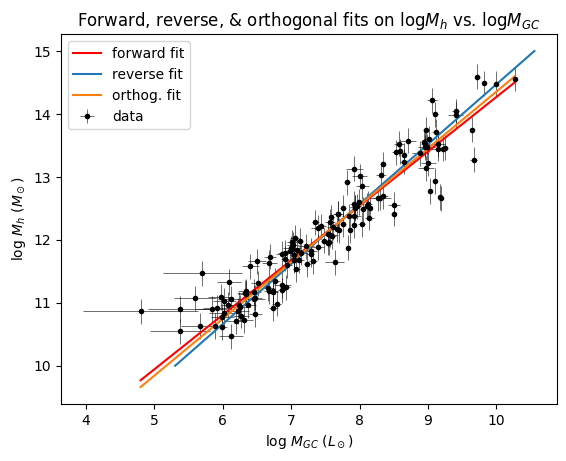

In [109]:
def logLikelihood_orthog(params, xb, yb, dxb, dyb):
    """
    Computes the log likelihood for orthogonal regression.

    Parameters:
    params (list): [a, b, sig] where:
        a   - intercept
        b   - slope
        sig - standard deviation
    xb (array): Data for the x variable.
    yb (array): Data for the y variable.
    dxb (array): Errors in the x data.
    dyb (array): Errors in the y data.

    Returns:
    float: Log likelihood for the orthogonal regression model.
    """
    a = params[0]
    b = params[1]
    sig = params[2]
    theta = np.arctan(b)
    
    delti = (yb - a)*np.cos(theta) - xb*np.sin(theta)
    SUMi2 = ((dyb * np.cos(theta))**2) + ((dxb * (np.sin(theta)))**2) + sig**2
    
    return -(-np.sum(np.log(SUMi2)) - np.sum((delti**2) / (SUMi2)))
    

o_ort = optimize.minimize(logLikelihood_orthog, np.array([1,1,1]), args=(MGC, Mh, dMGC, dMh))
a_ort = o_ort.x[0]
b_ort = o_ort.x[1]
sig_ort = o_ort.x[2]
da_ort = np.sqrt(o_ort.hess_inv[0,0])
db_ort = np.sqrt(o_ort.hess_inv[1,1])
dsig_ort = np.sqrt(o_ort.hess_inv[2,2])


print('orthogonal: a = %.4f +- %.4f  b = %.4f +- %.4f  sig = %.4f +- %.4f'%(a_ort, da_ort, b_ort, db_ort, sig_ort, dsig_ort))
print('--> compare with the forward fit: a = %.4f +- %.4f  b = %.4f +- %.4f  sig = %.4f +- %.4f'%(a_boot, da_boot, b_boot, db_boot, sig_boot, dsig_boot))

plt.errorbar(MGC, Mh, xerr=dMGC, yerr=dMh, fmt='.k', elinewidth=0.4, capsize=0, label='data')
plt.plot(xa, a_boot + b_boot*xa, 'r-', label='forward fit')
plt.plot(c_rev + d_rev * ya, ya, label='reverse fit')
plt.plot(xa, a_ort + b_ort*xa, label='orthog. fit')

plt.legend()
plt.title('Forward, reverse, & orthogonal fits on log$M_h$ vs. log$M_{GC}$')
plt.xlabel(r'log $M_{GC} \ (L_\odot)$');
plt.ylabel(r'log $M_h \ (M_\odot)$');

* The orthogonal fit finds a slope nearly consistent with 1, though it is off by 1/10, even with error. Compared with the forward fit, the parameter values are relatively nearby each other, though their value ranges with error almost never actually overlap, except for the intrinsic scatter.

## Task 7

7. Discuss the differences in the three "best-fits" above. Argue which one you prefer. What do all these results combined indicate about the slope of the $M_{GC} - M_h$ relation? Is it consistent with the slope of 1 within the estimated uncertainty?<br>

In [108]:
print('*Bootstrapped forward fit parameters: a = %.4f +/- %.4f, b = %.4f +/- %.4f, sig = %.4f +/- %.4f'\
    %(a_boot, da_boot, b_boot, db_boot, sig_boot, dsig_boot))
print(f"\n*From the reverse fit, c={c_rev:.4f}+/-{dc_rev:.4f} & d={d_rev:.4f}+/-{dd_rev:.4f}, which correspond to a'={aprime:.4f}+/-{daprime:.4f} & b'={bprime:.4f}+/-{dbprime:.4f}")
print('\n*Orthogonal fit: a = %.4f +/- %.4f  b = %.4f +/- %.4f  sig = %.4f +/- %.4f'%(a_ort, da_ort, b_ort, db_ort, sig_ort, dsig_ort))

*Bootstrapped forward fit parameters: a = 5.6139 +/- 0.2052, b = 0.8656 +/- 0.0279, sig = -0.1766 +/- 0.0980

*From the reverse fit, c=-5.1947+/-0.2251 & d=1.0500+/-0.0184, which correspond to a'=4.9474+/-0.2312 & b'=0.9524+/-0.0167

*Orthogonal fit: a = 5.3280 +/- 0.0100  b = 0.9027 +/- 0.0038  sig = 0.1537 +/- 0.0136


* Each of forward, reverse, and orthogonal linear fitting are different ways of modeling the relationship between our two variables log$M_h$ and log$M_{GC}$. A forward fit assumes $y$ vs. $x$, reverse fit $x$ vs. $y$, where we maximize the log likelihood of observing the data for each, and orthogonal fit $y$ vs. $x$ with minimization of perpendicular distance from the data to the regression line. We estimate the standard errors on all fit parameters: the slope and intercept of the line, as well as the intrinsic scatter in the data.
* I prefer the orthogonal fit as an in-between estimation of the forward and reverse fits. The orthogonal fit had the lowest errors on its fit parameters. It was also mostly consistent with a slope of nearly 1 with a standard range of ~[0.8989, 0.9065], though the slope of 1 is just an expectation. What is more important is the consistency and linearity of the fit with the data, as well as the strength of correlation in the data itself.
* Within an error, the range of possible slopes for each fit:
    * Forward [0.8377, 0.8935]
    * Reverse [0.9357, 0.9691]
    * Orthogonal [0.8989, 0.9065]
    * These ranges are all close enough to 1 for a slope of 1 to be a valid, but rough estimate of the linear log relationship between $M_h$ and $M_{GC}$. 

## Analysis

* Which numerical methods worked or did not work in this project
    * The maximization of log likelihoods for the forward and reverse fitting produced reliable best fit parameters and lines. The orthogonal fitting with minimization of perpendicular distances also worked similarly well.
    * Bootstrap statistics on forward-fitted relationship worked well and produced parameter distributions. The contours of LL(max) - LL also describe the parameters smoothly and closely.
* Lessons learned
    * I got to practice different methods of determining linear best fit parameters on a new dataset, as well as analyze the relationship/correlation between parameters.
    * I got to use error propogation to analyze derived parameters for comparing different regression methods.
    * I got to deepen my understanding of bootstrap statistics in practice.
* Further code improvements you could make with significantly more effort
    * I would've liked to work with adding a pivot point to the dataset, as well as incorporate an offset in the data to analyze differences in relationships.
    * I would've liked to compare these regression methods with another scipy routine like curve_fit.
 